#  特征选择

## 采用决策树模型，对Mushroom 数据集进行蘑菇毒性判断
根据决策树算法得到的特征重要性，采用wrapper的方式进行特征选择。

Kaggle竞赛蘑菇数据集，根据22维特征判断蘑菇是有毒/可食用。
https://www.kaggle.com/uciml/mushroom-classification

## 导入工具包

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading the file

调用head函数看看前5个样本各特征的值

In [2]:
df = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
#数据基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

很幸运，该数据没有空值／缺失数据

### 特征编码

特征全是类别型变量，很多模型需要数值型的输入（Logistic回归、xgboost...)
LableEncoder可以将类别型变量变成数值，但结果是有序的，而颜色等特征是没有序关系。
sklearn中的决策树算法也需要输入数值（OneHotEncoder）；如果采用LabelEncoder，也可以进行特征分裂，不过分裂的方式不如采用OneHotEncoder多。在这个例子中，LabelEncoder也可以得到完美的性能。
LightGBM支持类别型特征，采用基于直方图的方式进行特征分裂，采用LabelEncoder就好。

In [4]:
from sklearn.preprocessing import LabelEncoder 
labelencoder = LabelEncoder() 
for col in df.columns: 
    df[col] = labelencoder.fit_transform(df[col])
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


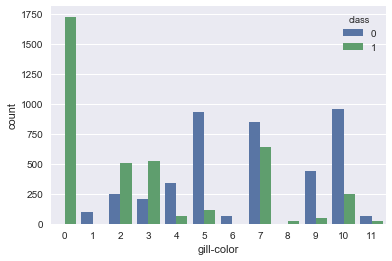

In [5]:
sns.countplot(x="gill-color", hue="class",data=df)

gill-color特征在class为0和1时候的分布明显不同，看起来是个很好的特征。

### 数据集是一个文件，分出一部分来做测试（不是校验集）

In [6]:
y = df['class']   
X = df.drop('class', axis = 1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [8]:
columns = X_train.columns

## 决策树超参数调优

决策树的超参数有：
1. max_depth（树的深度）或max_leaf_nodes（叶子结点的数目）、
2. min_samples_leaf（叶子结点的最小样本数）、min_samples_split（中间结点的最小样本树）、min_weight_fraction_leaf（叶子节点的样本权重占总权重的比例）
3. min_impurity_split（最小不纯净度）也可以调整
4. max_features（最大特征数目）、

这个数据集的任务不难，深度设为2-10之间

In [9]:
#1. 生成一个（待调超参数的）学习器的实例
dt = DecisionTreeClassifier()

#2. 设置超参数的搜索范围
max_depth = range(1,10,1)
min_samples_leaf = range(1,10,2)
tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

#3.生成一个GridSearchCV的实例，并调用其fit方法实现超参数调优
grid = GridSearchCV(dt, tuned_parameters, cv=10, verbose = 5)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV]  max_depth=1, min_samples_leaf=1, score=0.763440860215, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV]  max_depth=1, min_samples_leaf=1, score=0.783410138249, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV]  max_depth=1, min_samples_leaf=1, score=0.818740399386, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV]  max_depth=1, min_samples_leaf=1, score=0.790769230769, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV]  max_depth=1, min_samples_leaf=1, score=0.798461538462, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV]  max_depth=1, min_samples_leaf=1, score=0.776923076923, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1 ........................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=5, score=0.790769230769, total=   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.798461538462, total=   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.776923076923, total=   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.787365177196, total=   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.775038520801, total=   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.810477657935, total=   0.0s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV]  max_depth=1, min_samples_leaf=5, score=0.790446841294, total=   0.0s
[CV] max_depth=1, min_samples_leaf=7 ............

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    4.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=5)

In [10]:
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 1.000000 using {'max_depth': 7, 'min_samples_leaf': 1}


In [11]:
y_prob = grid.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
grid.score(X_test, y_pred)

1.0

In [12]:
print 'The AUC of GridSearchCV Desicion Tree is', roc_auc_score(y_test,y_pred)

The AUC of GridSearchCV Desicion Tree is 1.0


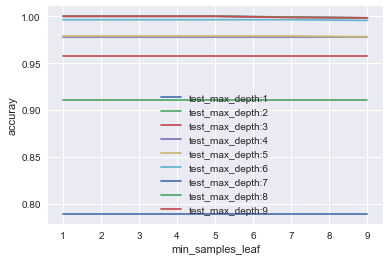

In [13]:
test_means = grid.cv_results_[ 'mean_test_score' ]
#test_stds = grid.cv_results_[ 'std_test_score' ]

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_samples_leaf))

for i, value in enumerate(max_depth):
    plt.plot(min_samples_leaf, test_scores[i], label= 'test_max_depth:'   + str(value))

    
plt.legend()
plt.xlabel( 'min_samples_leaf' )                                                                                                      
plt.ylabel( 'accuray' )
plt.show()

In [14]:
df_importance = pd.DataFrame({"columns":list(columns), "importance":list(grid.best_estimator_.feature_importances_.T)})
df_importance.sort_values(by=['importance'],ascending=False)

,columns,importance
8,gill-color,0.339965
19,spore-print-color,0.208067
20,population,0.173798
7,gill-size,0.117183
10,stalk-root,0.046127
21,habitat,0.032014
3,bruises,0.028990
9,stalk-shape,0.025458
13,stalk-color-above-ring,0.018352
11,stalk-surface-above-ring,0.003484


决策树模型选择了14个特征（共22个特征）

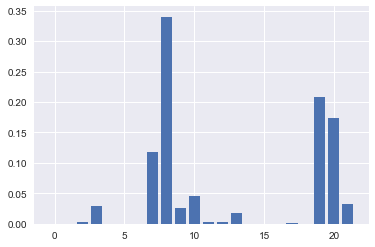

In [15]:
plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
plt.show()

## 特征选择
还能根据特征重要性做得更好？

In [16]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
best_dt = grid.best_estimator_
thresholds = sort(best_dt.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(best_dt, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # 对选好的特征，再次用GridSearchCV得到的最佳超参数
    selection_model = DecisionTreeClassifier()
    max_depth = range(3,7,1)
    min_samples_leaf = range(1,5,1)
    tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    
    grid = GridSearchCV(selection_model, tuned_parameters, cv=10, refit = False)
    grid.fit(select_X_train, y_train)
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
      grid.best_score_*100.0))

Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.000, n=22, Accuracy: 99.63%
Thresh=0.001, n=13, Accuracy: 99.63%
Thresh=0.002, n=12, Accuracy: 99.51%
Thresh=0.003, n=11, Accuracy: 99.51%
Thresh=0.003, n=10, Accuracy: 99.91%
Thresh=0.018, n=9, Accuracy: 99.91%
Thresh=0.025, n=8, Accuracy: 99.83%
Thresh=0.029, n=7, Accuracy: 98.86%
Thresh=0.032, n=6, Accuracy: 98.86%
Thresh=0.046, n=5, Accuracy: 98.78%
Thresh=0.117, n=4, Accuracy: 97.82%
Thresh=0.174, n=3, Accuracy: 93.26%
Thresh=0.208, n=2, Accuracy: 93.34%
Thresh=0.340, n=1, Accuracy: 80.38%


阈值为0.018，取9个特征的时候模型性能最好

In [17]:
#求最佳阈值对应的最佳超参数
thresh = 0.018
selection = SelectFromModel(best_dt, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
    
# 对选好的特征，再次用GridSearchCV得到的最佳超参数
selection_model = DecisionTreeClassifier()
max_depth = range(3,7,1)
min_samples_leaf = range(1,5,1)
tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    
grid = GridSearchCV(selection_model, tuned_parameters, cv=10)
grid.fit(select_X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.999077 using {'max_depth': 6, 'min_samples_leaf': 1}


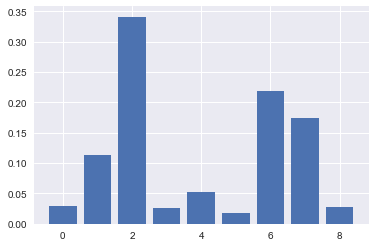

In [19]:
plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
plt.show()